In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import scipy.signal

In [2]:
data_matrix = np.load('extract/extact_matrix.npy', allow_pickle=True)

In [3]:

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


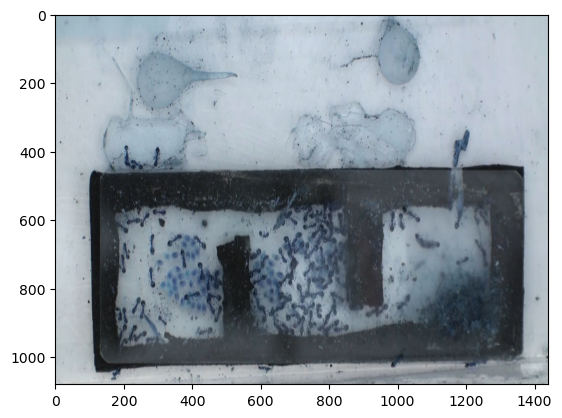

In [4]:
plt.imshow(data_matrix[0])

In [5]:
#data_marix_gray=np.mean(data_marix,axis=3)
data_matrix_gray = np.load('extract/extact_matrix_uni.npy', allow_pickle=True)

Gaussien filter

## thresholding

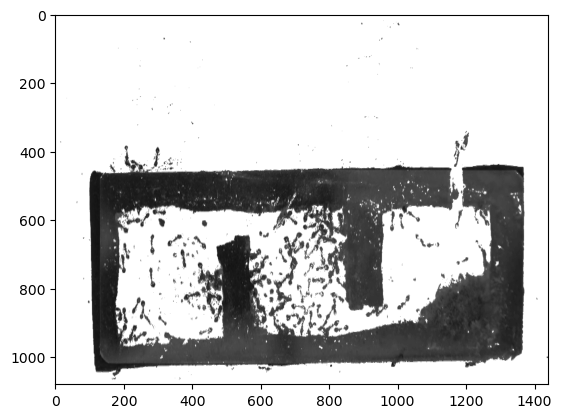

In [57]:
test=np.where(data_matrix_gray[0]>90,255,data_matrix_gray[0])
plt.imshow(test, cmap='gray')

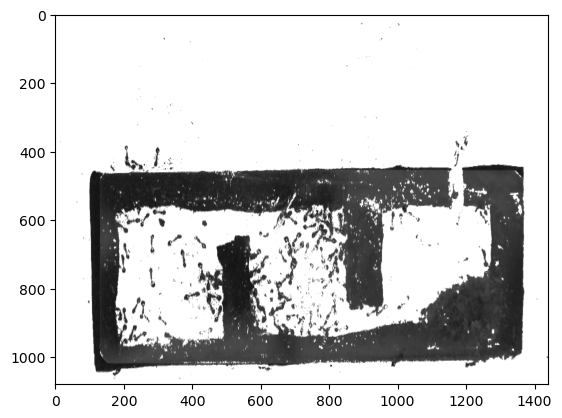

In [26]:
test1=np.where(data_matrix_gray[1]>80,255,0)
plt.imshow(test, cmap='gray')

## substraction

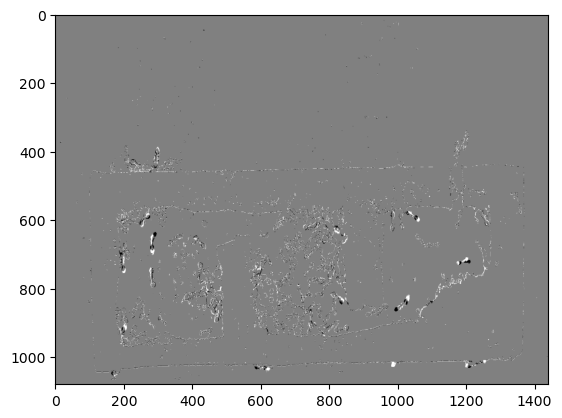

In [10]:
pos=np.where(test1-test>0,0,255)
neg=np.where(test1-test<0,0,255)
plt.imshow(test1-test, cmap='gray')

In [11]:
sub=test1-test

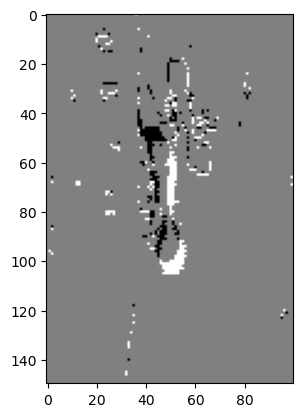

In [12]:
plt.imshow(sub[650:800,150:250],cmap='gray')

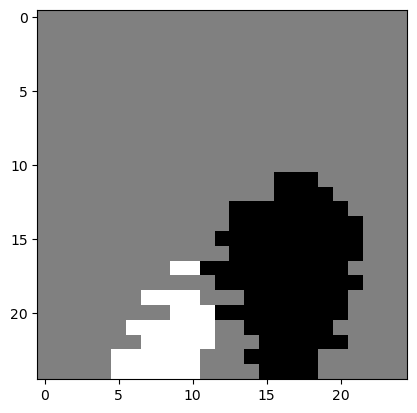

In [13]:
plt.imshow(sub[625:650,275:300],cmap='gray')

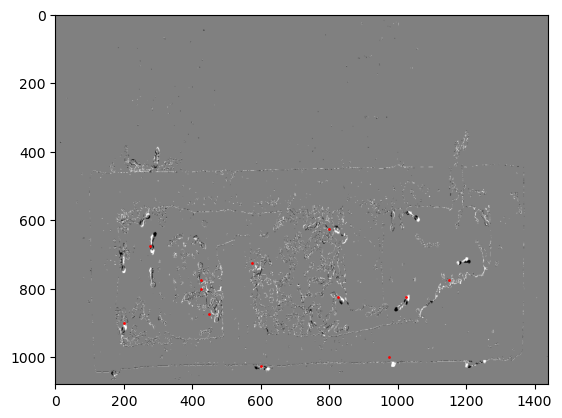

In [66]:
plt.imshow(sub, cmap='gray')
plt.scatter(list_y, list_x, c='r', s=1)
plt.show()

## Find points

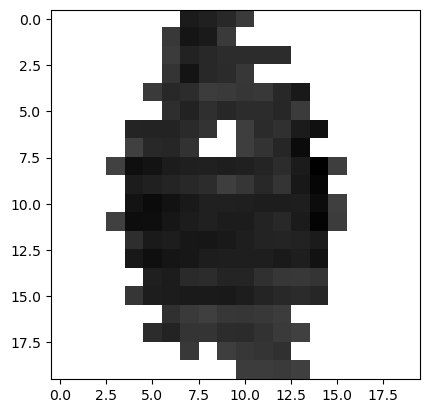

In [68]:
plt.imshow(test[680:700,275:295],cmap='gray')

In [69]:
np.mean(test[680:700,275:295])

174.42333333333335

In [9]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # compute the derivatives
    Ix = convolve2d(image, np.array([[-1, 0, 1]]), mode='same')
    Iy = convolve2d(image, np.array([[-1, 0, 1]]).T, mode='same')
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    # compute the gaussian kernel
    kern = gaussianKernel(scale)
    # compute the sum of the squares of the derivatives
    Sxx = convolve2d(Ixx, kern, mode='same')
    Syy = convolve2d(Iyy, kern, mode='same')
    Sxy = convolve2d(Ixy, kern, mode='same')
    # compute the R matrix
    R = (Sxx*Syy - Sxy**2) - kappa*(Sxx+Syy)**2
    return R

In [10]:
def rnms(image_harris,Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    # compute the size of the image
    n,m = image_harris.shape
    # create a new image
    image_rnms = np.zeros((n,m))
    # for each pixel
    for i in range(1,n-1):
        for j in range(1,m-1):
            # if the pixel is a local maximum,check if the pixel is the local maximum of its 8-neighborhood
            if Rbin[i,j] == 1 and np.max(image_harris[i-1:i+2, j-1:j+2]) == image_harris[i,j]:
                image_rnms[i,j] = 1
    return image_rnms

def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, sigma, kappa)
    max,min=R.max(),R.min()
    Rnorm=(R-min)/(max-min)
    Rbin = thresholdR(Rnorm, thres)
    image_rnms = rnms(Rnorm, Rbin)
    return image_rnms

def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R>thres, 1, 0))

In [12]:
import cv2

In [13]:
smooth_fourmis = cv2.GaussianBlur(test,(5,5),0)

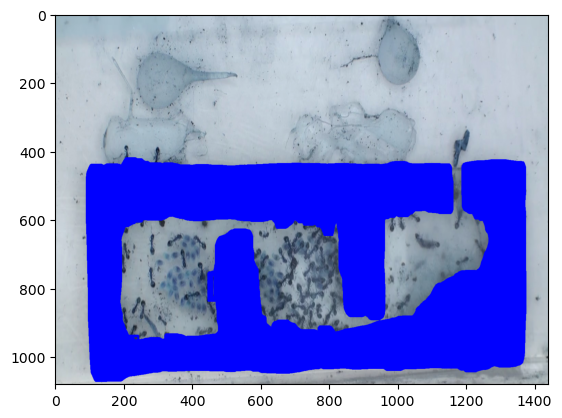

In [14]:
img_rgb = data_matrix[0].astype(np.uint8)
img_gray = smooth_fourmis.astype(np.uint8)
template = smooth_fourmis[625:700,275:300].astype(np.uint8)
w, h = template.shape[::-1]
res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
plt.imshow(img_rgb)


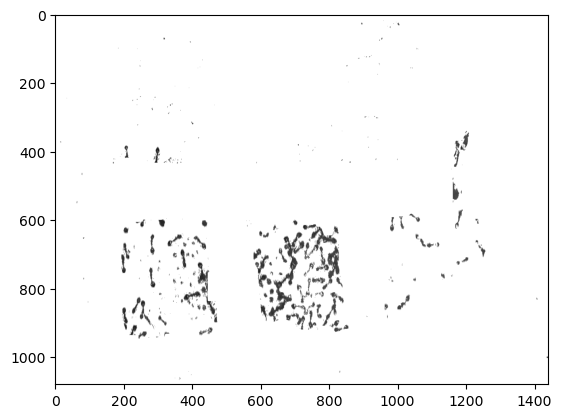

In [76]:
new=test.copy()
for i,j in zip(*loc[::-1]):
    new[j:j+h,i:i+w]=255
plt.imshow(new, cmap='gray')

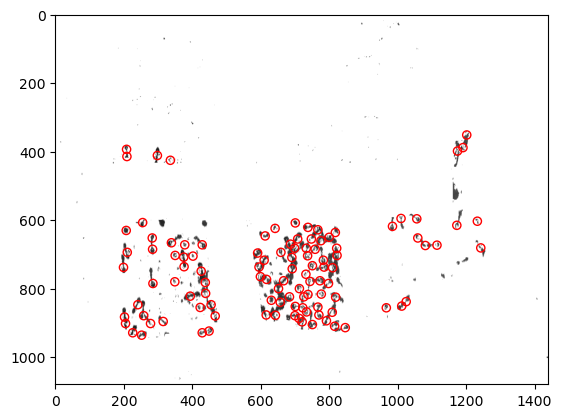

In [62]:
sigma=6
kappa=0.04
thres=0.2
image_rnms = cornerDetector(new, sigma, kappa, thres)

n2=int(np.ceil(3*sigma))
x,y=np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
corners=np.argwhere(image_rnms==1)
plt.imshow(new,cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

In [118]:
lines=[]
for tuple1 in corners:
    for tuple2 in corners:
        mean=np.mean([tuple1,tuple2],axis=0)
        if (tuple1[1]!=tuple2[1] or tuple1[0]!=tuple2[0] )and np.linalg.norm(tuple1-tuple2)<50 and np.linalg.norm(tuple1-tuple2)>30 and new[int(mean[0]),int(mean[1])]<100:
            lines.append([tuple1,tuple2])
lines=np.array(lines)

In [117]:
corners[3],corners[4]

(array([ 398, 1175]), array([411, 298]))

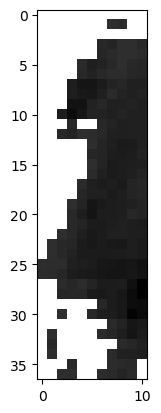

In [115]:
plt.imshow(new[corners[0][0]:corners[1][0],corners[1][1]:corners[0][1]],cmap='gray')

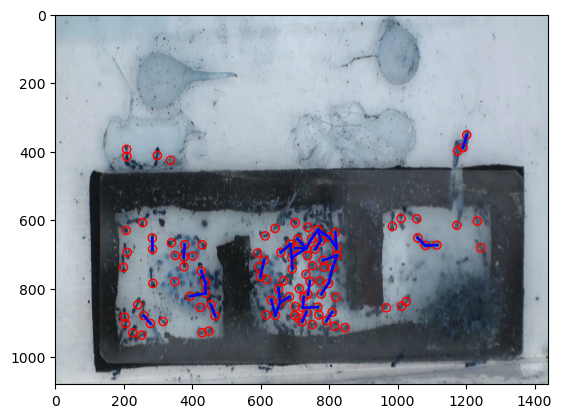

In [120]:
for line in lines:
    plt.plot([line[0][1],line[1][1]],[line[0][0],line[1][0]],c='b')
plt.imshow(data_matrix[0],cmap='gray')
plt.scatter(corners[:,1],corners[:,0],s=2*n2-1,marker='o',edgecolors='r',facecolors='none')
plt.show()

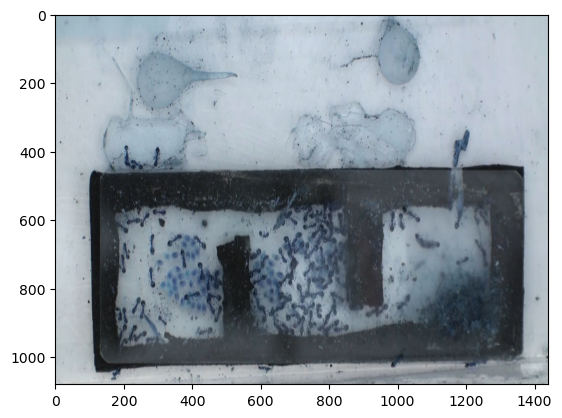

In [18]:
plt.imshow(data_matrix[0],cmap='gray')